In [ ]:
import os
import torch
import numpy as np
from PIL import Image
from torchvision import transforms
from tqdm import tqdm
import torch.nn as nn

# --- PatchVAE Definition ---
class PatchVAE(nn.Module):
    def __init__(self, latent_channels=64, latent_hw=2):
        super().__init__()
        self.latent_channels = latent_channels
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 4, 2, 1),   # 32 → 16
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, 1),  # 16 → 8
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, 2, 1), # 8 → 4
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, 1, 1),  # keep 4×4
            nn.ReLU()
        )
        self.conv_mu = nn.Conv2d(128, latent_channels, 1)
        self.conv_logvar = nn.Conv2d(128, latent_channels, 1)
        self.decoder = nn.Sequential(  # Needed for loading checkpoint
            nn.ConvTranspose2d(latent_channels, 128, 3, 1, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, 2, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 4, 2, 1),
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder(x)
        mu = self.conv_mu(h)
        return mu

# --- Patch extraction from large image ---
def extract_patches(img, patch_size=32, stride=32):
    patches = []
    w, h = img.size  # PIL format
    for top in range(0, h - patch_size + 1, stride):
        for left in range(0, w - patch_size + 1, stride):
            patch = img.crop((left, top, left + patch_size, top + patch_size))
            patch_tensor = transforms.ToTensor()(patch).unsqueeze(0)  # (1, 3, 32, 32)
            patches.append(patch_tensor)
    return patches

# --- Paths ---
vae_ckpt = "/content/drive/MyDrive/latent_exp_2025/training_ckpts_64_latent_tensors_2_2_quantized_larger_data/vae_epoch_60.pt"
img_dir = "/content/drive/MyDrive/latent_exp_2025/training_images_"
save_path = "/content/drive/MyDrive/latent_exp_2025/vae_latents.npy"
MAX_LATENTS = 100000

# --- Load VAE ---
vae = PatchVAE(latent_channels=64, latent_hw=2)
checkpoint = torch.load(vae_ckpt, map_location='cpu')
vae.load_state_dict(checkpoint["model_state_dict"])
vae.eval()

# --- Load images ---
img_files = sorted([
    f for f in os.listdir(img_dir)
    if f.lower().endswith(('.png', '.jpg', '.jpeg'))
])

# --- Collect Latents ---
latents = []
with torch.no_grad():
    for fname in tqdm(img_files, desc="Extracting latents"):
        if len(latents) >= MAX_LATENTS:
            break
        img_path = os.path.join(img_dir, fname)
        img = Image.open(img_path).convert("RGB")
        patches = extract_patches(img)

        for patch in patches:
            if len(latents) >= MAX_LATENTS:
                break
            mu = vae.encode(patch)  # → (1, 64, 4, 4)
            latents.append(mu.squeeze(0).numpy())  # → (64, 4, 4)

# --- Save ---
latents = np.stack(latents)  # → (N, 64, 4, 4)
np.save(save_path, latents)
print(f"✅ Saved {latents.shape[0]} latent tensors to {save_path}")


Extracting latents:  10%|▉         | 19/194 [01:23<12:50,  4.40s/it]


✅ Saved 50000 latent tensors to /content/drive/MyDrive/latent_exp_2025/vae_latents.npy


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data = np.load('/content/drive/MyDrive/latent_exp_2025/chunked_dataset_pattern_40k/dataset_chunk_00.npy', allow_pickle=True)

# Print the type and shape of the loaded data
print("Type:", type(data))
print("Shape:", data.shape if hasattr(data, 'shape') else 'No shape attribute')

# If it's an array, you can also check a few elements
print("First item(s):", data[:1])

Type: <class 'numpy.ndarray'>
Shape: (1000, 2, 128, 128, 3)
First item(s): [[[[[0.14117648 0.12156863 0.11764706]
    [0.12941177 0.11372549 0.10588235]
    [0.14117648 0.1254902  0.11372549]
    ...
    [0.05098039 0.04313726 0.04705882]
    [0.05490196 0.04313726 0.05098039]
    [0.06666667 0.07450981 0.08235294]]

   [[0.12941177 0.10196079 0.09019608]
    [0.1254902  0.09019608 0.07843138]
    [0.13333334 0.09019608 0.07843138]
    ...
    [0.05882353 0.03921569 0.03137255]
    [0.0627451  0.04705882 0.03921569]
    [0.0627451  0.05490196 0.05490196]]

   [[0.14117648 0.10980392 0.10196079]
    [0.13333334 0.09803922 0.07843138]
    [0.12941177 0.09019608 0.07843138]
    ...
    [0.05882353 0.03921569 0.02745098]
    [0.06666667 0.04705882 0.03529412]
    [0.06666667 0.0627451  0.05882353]]

   ...

   [[0.2901961  0.2509804  0.1882353 ]
    [0.2901961  0.25882354 0.19607843]
    [0.29411766 0.2627451  0.20392157]
    ...
    [0.11764706 0.07058824 0.05882353]
    [0.11764706 0.070

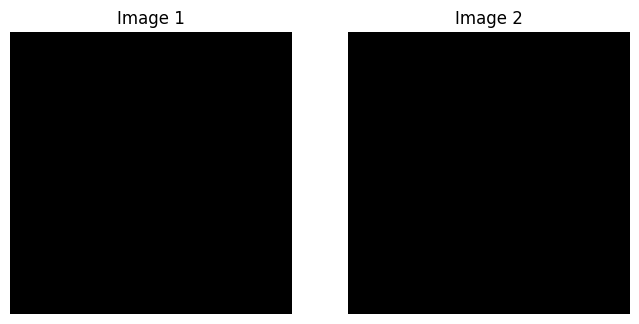

In [ ]:
import matplotlib.pyplot as plt

# Pick the first data pair
img1, img2 = data[0]

# Show both images side by side
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(img1.astype(np.uint8))
plt.title("Image 1")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(img2.astype(np.uint8))
plt.title("Image 2")
plt.axis("off")
plt.show()


In [ ]:
import os
import torch
import numpy as np
from PIL import Image
from torchvision import transforms
from tqdm import tqdm
import torch.nn as nn
import numpy as np
from PIL import Image
from torchvision import transforms

# --- PatchVAE Definition ---
class PatchVAE(nn.Module):
    def __init__(self, latent_channels=64, latent_hw=2):
        super().__init__()
        self.latent_channels = latent_channels
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 4, 2, 1),   # 32 → 16
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, 1),  # 16 → 8
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, 2, 1), # 8 → 4
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, 1, 1),  # keep 4×4
            nn.ReLU()
        )
        self.conv_mu = nn.Conv2d(128, latent_channels, 1)
        self.conv_logvar = nn.Conv2d(128, latent_channels, 1)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(latent_channels, 128, 3, 1, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, 2, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 4, 2, 1),
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder(x)
        mu = self.conv_mu(h)
        return mu

# --- Selective patch extractor (every 3rd patch) ---
def extract_patches_selective(img, patch_size=32, stride=32):
    patches = []
    w, h = img.size
    count = 0  # Index of patch
    for top in range(0, h - patch_size + 1, stride):
        for left in range(0, w - patch_size + 1, stride):
            if count % 3 == 0:
                patch = img.crop((left, top, left + patch_size, top + patch_size))
                patch_tensor = transforms.ToTensor()(patch).unsqueeze(0)  # (1, 3, 32, 32)
                patches.append(patch_tensor)
            count += 1
    return patches

# --- Paths and constants ---
vae_ckpt = "/content/drive/MyDrive/latent_exp_2025/training_ckpts_64_latent_tensors_2_2_quantized_larger_data/vae_epoch_60.pt"
img_dir = "/content/drive/MyDrive/latent_exp_2025/training_images_"
save_path = "/content/drive/MyDrive/latent_exp_2025/vae_latents.npy"
MAX_LATENTS = 80000

# --- Load VAE ---
vae = PatchVAE(latent_channels=64, latent_hw=2)
checkpoint = torch.load(vae_ckpt, map_location='cpu')
vae.load_state_dict(checkpoint["model_state_dict"])
vae.eval()

# --- Load image list ---
img_files = sorted([
    f for f in os.listdir(img_dir)
    if f.lower().endswith(('.png', '.jpg', '.jpeg'))
])

# --- Extract and Save Latents ---
latents = []
with torch.no_grad():
    for fname in tqdm(img_files, desc="Extracting latents"):
        if len(latents) >= MAX_LATENTS:
            break
        img_path = os.path.join(img_dir, fname)
        img = Image.open(img_path).convert("RGB")
        patches = extract_patches_selective(img)

        for patch in patches:
            if len(latents) >= MAX_LATENTS:
                break
            mu = vae.encode(patch)  # → (1, 64, 4, 4)
            latents.append(mu.squeeze(0).numpy())  # → (64, 4, 4)

latents = np.stack(latents)  # → (N, 64, 4, 4)
np.save(save_path, latents)
print(f"✅ Saved {latents.shape[0]} latent tensors to {save_path}")


KeyboardInterrupt: 

**SIMCLR style attention network (non quantized)**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import os
from PIL import Image
from torchvision import transforms
from tqdm import tqdm

In [ ]:
class LatentSimCLRProjection(nn.Module):
    def __init__(self, in_channels=64, proj_dim=128):
        super().__init__()
        self.backbone = nn.Sequential(
            nn.Conv2d(in_channels, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten()
        )
        self.projection = nn.Sequential(
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, proj_dim)
        )

    def forward(self, z):
        h = self.backbone(z)
        proj = self.projection(h)
        return F.normalize(proj, dim=-1)

In [ ]:
def nt_xent_loss(z1, z2, temperature=0.5):
    z = torch.cat([z1, z2], dim=0)  # [2B, D]
    sim = F.cosine_similarity(z.unsqueeze(1), z.unsqueeze(0), dim=2)  # [2B, 2B]

    N = z.size(0)
    sim = sim / temperature

    labels = torch.arange(N // 2, device=z.device)
    labels = torch.cat([labels, labels], dim=0)

    mask = torch.eye(N, dtype=torch.bool, device=z.device)
    sim = sim.masked_fill(mask, float('-inf'))

    positives = torch.cat([torch.diag(sim, N//2), torch.diag(sim, -N//2)])
    numerator = torch.exp(positives)
    denominator = torch.exp(sim).sum(dim=1)

    loss = -torch.log(numerator / denominator)
    return loss.mean()

In [ ]:
class LatentPatchDataset(Dataset):
    def __init__(self, npy_path):
        """
        Args:
            npy_path (str): Path to .npy file containing latent tensors of shape (N, 64, 4, 4)
        """
        self.latents = np.load(npy_path)  # → (N, 64, 4, 4)

    def __len__(self):
        return len(self.latents)

    def augment(self, z):
        """Apply light augmentation in latent space: noise + scaling"""
        if not isinstance(z, torch.Tensor):
            z = torch.tensor(z, dtype=torch.float32)

        # Add uniform noise
        if torch.rand(1).item() < 0.5:
            z = z + torch.empty_like(z).uniform_(-0.25, 0.25)

        # Apply light random scaling
        if torch.rand(1).item() < 0.5:
            scale = 0.8 + 0.4 * torch.rand(1).item()  # Scale ∈ [0.8, 1.2]
            z = z * scale

        return z

    def __getitem__(self, idx):
        z = self.latents[idx]  # (64, 4, 4)
        z1 = self.augment(z)
        z2 = self.augment(z)
        return z1, z2  # Both are torch.FloatTensor of shape (64, 4, 4)

In [ ]:
npy_path = "/content/drive/MyDrive/latent_exp_2025/vae_latents.npy"
batch_size = 256
num_epochs = 100
temperature = 0.5
proj_dim = 128
device = 'cuda' if torch.cuda.is_available() else 'cpu'
save_dir = "/content/drive/MyDrive/latent_exp_2025/attention_network_checkpoints"
os.makedirs(save_dir, exist_ok=True)

# --- Training ---
dataset = LatentPatchDataset(npy_path)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

model = LatentSimCLRProjection(in_channels=64, proj_dim=proj_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(num_epochs):
    total_loss = 0
    model.train()
    for z1, z2 in dataloader:
        z1 = z1.to(device)
        z2 = z2.to(device)

        proj1 = model(z1)
        proj2 = model(z2)

        loss = nt_xent_loss(proj1, proj2, temperature)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    print(f"Epoch {epoch+1:03d} | Loss: {avg_loss:.4f}")

    # Save checkpoint every 4th epoch
    if (epoch + 1) % 4 == 0:
        ckpt_path = os.path.join(save_dir, f"attention_epoch_{epoch+1}.pt")
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': avg_loss
        }, ckpt_path)
        print(f"✅ Saved checkpoint to {ckpt_path}")

Epoch 001 | Loss: 4.4903
Epoch 002 | Loss: 4.3640
Epoch 003 | Loss: 4.3454
Epoch 004 | Loss: 4.3359
✅ Saved checkpoint to /content/drive/MyDrive/latent_exp_2025/attention_network_checkpoints/attention_epoch_4.pt
Epoch 005 | Loss: 4.3276
Epoch 006 | Loss: 4.3221
Epoch 007 | Loss: 4.3184
Epoch 008 | Loss: 4.3163
✅ Saved checkpoint to /content/drive/MyDrive/latent_exp_2025/attention_network_checkpoints/attention_epoch_8.pt
Epoch 009 | Loss: 4.3133
Epoch 010 | Loss: 4.3125
Epoch 011 | Loss: 4.3110
Epoch 012 | Loss: 4.3102
✅ Saved checkpoint to /content/drive/MyDrive/latent_exp_2025/attention_network_checkpoints/attention_epoch_12.pt
Epoch 013 | Loss: 4.3082
Epoch 014 | Loss: 4.3068
Epoch 015 | Loss: 4.3065
Epoch 016 | Loss: 4.3055
✅ Saved checkpoint to /content/drive/MyDrive/latent_exp_2025/attention_network_checkpoints/attention_epoch_16.pt
Epoch 017 | Loss: 4.3049
Epoch 018 | Loss: 4.3041
Epoch 019 | Loss: 4.3031
Epoch 020 | Loss: 4.3028
✅ Saved checkpoint to /content/drive/MyDrive/laten

KeyboardInterrupt: 

SyntaxError: invalid syntax (ipython-input-1-3106084930.py, line 1)

**QUANTIZED VERSION**

In [ ]:
import os
import torch
import torch.nn as nn
import numpy as np
from PIL import Image
from torchvision import transforms
from tqdm import tqdm

# --- PatchVAE Definition ---
class PatchVAE(nn.Module):
    def __init__(self, latent_channels=64):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 4, 2, 1),   # 32 → 16
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, 1),  # 16 → 8
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, 2, 1), # 8 → 4
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, 1, 1),  # keep 4×4
            nn.ReLU()
        )
        self.conv_mu = nn.Conv2d(128, latent_channels, 1)
        self.conv_logvar = nn.Conv2d(128, latent_channels, 1)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(latent_channels, 128, 3, 1, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, 2, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 4, 2, 1),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def quantize_test(self, z):
        return torch.round(z)

    def encode(self, x, quantize=True):
        h = self.encoder(x)
        mu = self.conv_mu(h)
        logvar = self.conv_logvar(h)
        z = self.reparameterize(mu, logvar)
        return self.quantize_test(z) if quantize else z

# --- Patch extractor (extract all patches) ---
def extract_patches(img, patch_size=32, stride=32):
    patches = []
    w, h = img.size
    for top in range(0, h - patch_size + 1, stride):
        for left in range(0, w - patch_size + 1, stride):
            patch = img.crop((left, top, left + patch_size, top + patch_size))
            patch_tensor = transforms.ToTensor()(patch).unsqueeze(0)
            patches.append(patch_tensor)
    return patches

# --- Paths and constants ---
vae_ckpt = "/content/drive/MyDrive/latent_exp_2025/training_ckpts_64_latent_tensors_2_2_quantized_larger_data/vae_epoch_60.pt"
img_dir = "/content/drive/MyDrive/latent_exp_2025/training_images_"
save_path = "/content/drive/MyDrive/latent_exp_2025/vae_latents_quantized.npy"
MAX_LATENTS = 100000

# --- Load VAE ---
device = 'cuda' if torch.cuda.is_available() else 'cpu'
vae = PatchVAE(latent_channels=64).to(device)
checkpoint = torch.load(vae_ckpt, map_location=device)
vae.load_state_dict(checkpoint["model_state_dict"], strict=False)  # Allows decoder mismatch
vae.eval()

# --- Load image list ---
img_files = sorted([
    f for f in os.listdir(img_dir)
    if f.lower().endswith(('.png', '.jpg', '.jpeg'))
])

# --- Extract and Save Quantized Latents ---
latents = []
with torch.no_grad():
    for fname in tqdm(img_files, desc="Extracting quantized latents"):
        if len(latents) >= MAX_LATENTS:
            break
        img_path = os.path.join(img_dir, fname)
        img = Image.open(img_path).convert("RGB")
        patches = extract_patches(img)

        for i, patch in enumerate(patches):
            if len(latents) >= MAX_LATENTS:
                break
            if i % 3 != 0:
                continue  # Keep only every 3rd patch
            patch = patch.to(device)
            z_hat = vae.encode(patch, quantize=True)
            latents.append(z_hat.squeeze(0).cpu().numpy())

# --- Save latents ---
latents = np.stack(latents)
np.save(save_path, latents)
print(f"✅ Saved {latents.shape[0]} quantized latent tensors to {save_path}")



Extracting quantized latents:  90%|█████████ | 175/194 [01:45<00:11,  1.66it/s]


✅ Saved 100000 quantized latent tensors to /content/drive/MyDrive/latent_exp_2025/vae_latents_quantized.npy


In [ ]:
import numpy as np

# Load the saved latent tensor file
latent_path = "/content/drive/MyDrive/latent_exp_2025/vae_latents_quantized.npy"
latents = np.load(latent_path)

# Print metadata
print(f"Type: {type(latents)}")
print(f"Shape: {latents.shape}")  # (N, C, H, W)

# Inspect one latent (e.g., the first one)
index = 0
latent_sample = latents[index]

print(f"\nLatent[{index}] shape: {latent_sample.shape}")
print(latent_sample)


Type: <class 'numpy.ndarray'>
Shape: (100000, 64, 4, 4)

Latent[0] shape: (64, 4, 4)
[[[ 0.  1.  1. -1.]
  [-0. -0. -0. -2.]
  [-0.  1. -0.  0.]
  [ 1. -1.  0. -1.]]

 [[ 0. -1.  0.  0.]
  [-0. -0. -0.  1.]
  [ 0. -1.  2.  1.]
  [-1. -0. -0.  2.]]

 [[-0.  0. -1. -1.]
  [-1.  1.  2.  1.]
  [ 0.  0.  2.  1.]
  [ 1. -0.  1. -0.]]

 ...

 [[ 1.  1.  0. -1.]
  [ 1. -1.  0. -1.]
  [-1. -0.  1. -1.]
  [ 2.  0.  2.  0.]]

 [[-1. -0. -1. -1.]
  [-1.  0.  1. -0.]
  [-1.  0. -3.  1.]
  [-1.  0.  1.  0.]]

 [[ 2. -1. -1. -2.]
  [ 1.  1. -1. -0.]
  [-1. -0.  1.  0.]
  [ 2.  0. -1.  2.]]]


In [ ]:
npy_path = "/content/drive/MyDrive/latent_exp_2025/vae_latents_quantized.npy"
batch_size = 256
num_epochs = 100
temperature = 0.5
proj_dim = 128
device = 'cuda' if torch.cuda.is_available() else 'cpu'
save_dir = "/content/drive/MyDrive/latent_exp_2025/attention_network_checkpoints_for_quantized"
os.makedirs(save_dir, exist_ok=True)

# --- Training ---
dataset = LatentPatchDataset(npy_path)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

model = LatentSimCLRProjection(in_channels=64, proj_dim=proj_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(num_epochs):
    total_loss = 0
    model.train()
    for z1, z2 in dataloader:
        z1 = z1.to(device)
        z2 = z2.to(device)

        proj1 = model(z1)
        proj2 = model(z2)

        loss = nt_xent_loss(proj1, proj2, temperature)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    print(f"Epoch {epoch+1:03d} | Loss: {avg_loss:.4f}")

    # Save checkpoint every 4th epoch
    if (epoch + 1) % 4 == 0:
        ckpt_path = os.path.join(save_dir, f"attention_epoch_{epoch+1}.pt")
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': avg_loss
        }, ckpt_path)
        print(f"✅ Saved checkpoint to {ckpt_path}")

Epoch 001 | Loss: 4.4184
Epoch 002 | Loss: 4.3276
Epoch 003 | Loss: 4.3195
Epoch 004 | Loss: 4.3154
✅ Saved checkpoint to /content/drive/MyDrive/latent_exp_2025/attention_network_checkpoints_for_quantized/attention_epoch_4.pt
Epoch 005 | Loss: 4.3127
Epoch 006 | Loss: 4.3106
Epoch 007 | Loss: 4.3088
Epoch 008 | Loss: 4.3073
✅ Saved checkpoint to /content/drive/MyDrive/latent_exp_2025/attention_network_checkpoints_for_quantized/attention_epoch_8.pt
Epoch 009 | Loss: 4.3061
Epoch 010 | Loss: 4.3052
Epoch 011 | Loss: 4.3043
Epoch 012 | Loss: 4.3036
✅ Saved checkpoint to /content/drive/MyDrive/latent_exp_2025/attention_network_checkpoints_for_quantized/attention_epoch_12.pt
Epoch 013 | Loss: 4.3029
Epoch 014 | Loss: 4.3028
Epoch 015 | Loss: 4.3020
Epoch 016 | Loss: 4.3017
✅ Saved checkpoint to /content/drive/MyDrive/latent_exp_2025/attention_network_checkpoints_for_quantized/attention_epoch_16.pt
Epoch 017 | Loss: 4.3008
Epoch 018 | Loss: 4.3006
Epoch 019 | Loss: 4.3001
Epoch 020 | Loss: 4

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

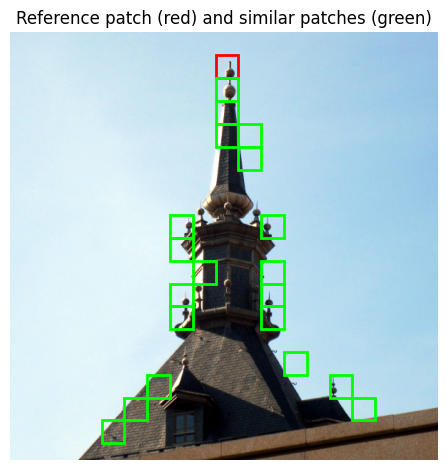

In [ ]:
image_path = "/content/drive/MyDrive/latent_exp_2025/RGB_R02_0600x0600_004.png"
vae_ckpt = "/content/drive/MyDrive/latent_exp_2025/training_ckpts_64_latent_tensors_2_2_quantized_larger_data/vae_epoch_60.pt"
simclr_ckpt = "/content/drive/MyDrive/latent_exp_2025/attention_network_checkpoints/attention_epoch_60.pt"

patch_size = 32
stride = 32
proj_dim = 128
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# --- VAE Definition ---
import torch.nn as nn
import torch.nn.functional as F

class PatchVAE(nn.Module):
    def __init__(self, latent_channels=64, latent_hw=2):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 4, 2, 1), nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, 1), nn.ReLU(),
            nn.Conv2d(64, 128, 4, 2, 1), nn.ReLU(),
            nn.Conv2d(128, 128, 3, 1, 1), nn.ReLU()
        )
        self.conv_mu = nn.Conv2d(128, latent_channels, 1)
        self.conv_logvar = nn.Conv2d(128, latent_channels, 1)
        self.decoder = nn.Sequential(  # required to load weights
            nn.ConvTranspose2d(latent_channels, 128, 3, 1, 1), nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1), nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, 2, 1), nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 4, 2, 1), nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder(x)
        mu = self.conv_mu(h)
        return mu

# --- SimCLR Model ---
class LatentSimCLRProjection(nn.Module):
    def __init__(self, in_channels=64, proj_dim=128):
        super().__init__()
        self.backbone = nn.Sequential(
            nn.Conv2d(in_channels, 128, 3, 1, 1), nn.ReLU(),
            nn.Conv2d(128, 256, 3, 1, 1), nn.ReLU(),
            nn.AdaptiveAvgPool2d(1), nn.Flatten()
        )
        self.projection = nn.Sequential(
            nn.Linear(256, 256), nn.ReLU(),
            nn.Linear(256, proj_dim)
        )

    def forward(self, z):
        h = self.backbone(z)
        proj = self.projection(h)
        return F.normalize(proj, dim=-1)

# --- Patch extraction ---
def extract_patches(img, patch_size=32, stride=32):
    w, h = img.size
    patches = []
    coords = []
    for top in range(0, h - patch_size + 1, stride):
        for left in range(0, w - patch_size + 1, stride):
            patch = img.crop((left, top, left + patch_size, top + patch_size))
            coords.append((left, top))
            patch_tensor = transforms.ToTensor()(patch).unsqueeze(0)  # (1, 3, 32, 32)
            patches.append(patch_tensor)
    return patches, coords

# --- Load image and models ---
image = Image.open(image_path).convert("RGB")
vae = PatchVAE().to(device)
vae.load_state_dict(torch.load(vae_ckpt, map_location=device)["model_state_dict"])
vae.eval()

simclr_model = LatentSimCLRProjection().to(device)
simclr_model.load_state_dict(torch.load(simclr_ckpt, map_location=device)["model_state_dict"])
simclr_model.eval()

patches, coords = extract_patches(image)
proj_vectors = []
all_latent_tensors = []

# --- Get latent projections ---
with torch.no_grad():
    for patch in patches:
        patch = patch.to(device)
        mu = vae.encode(patch)
        proj = simclr_model(mu)
        proj_vectors.append(proj.squeeze(0).cpu().numpy())
        all_latent_tensors.append(mu.squeeze(0).cpu().numpy())

# --- Cosine similarity ---
proj_vectors = np.stack(proj_vectors)
sim_matrix = cosine_similarity(proj_vectors)

# --- Select reference patch ---
#ref_idx = len(proj_vectors) // 8  # middle patch
ref_idx = 27
top_k = 20
similar_idxs = np.argsort(sim_matrix[ref_idx])[::-1][1:top_k+1]

# --- Visualize result ---
fig, ax = plt.subplots()
ax.imshow(image)
ax.set_title("Reference patch (red) and similar patches (green)")

# Draw boxes
ref_x, ref_y = coords[ref_idx]
ax.add_patch(plt.Rectangle((ref_x, ref_y), patch_size, patch_size, edgecolor='red', facecolor='none', linewidth=2))
for i in similar_idxs:
    x, y = coords[i]
    ax.add_patch(plt.Rectangle((x, y), patch_size, patch_size, edgecolor='lime', facecolor='none', linewidth=2))

plt.axis('off')
plt.tight_layout()
plt.show()

**QUANTIZED VERSION**

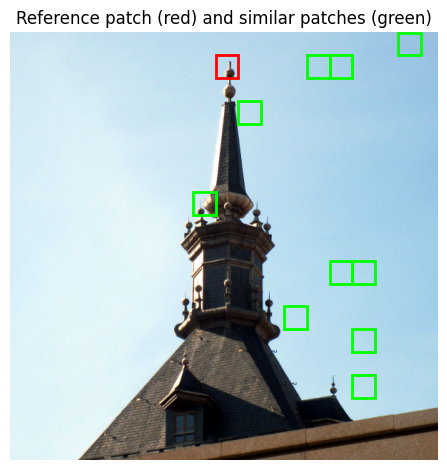

In [ ]:
image_path = "/content/drive/MyDrive/latent_exp_2025/RGB_R02_0600x0600_004.png"
vae_ckpt = "/content/drive/MyDrive/latent_exp_2025/training_ckpts_64_latent_tensors_2_2_quantized_larger_data/vae_epoch_60.pt"
simclr_ckpt = "/content/drive/MyDrive/latent_exp_2025/attention_network_checkpoints_for_quantized/attention_epoch_100.pt"

patch_size = 32
stride = 32
proj_dim = 128
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# --- VAE Definition ---
import torch.nn as nn
import torch.nn.functional as F

class PatchVAE(nn.Module):
    def __init__(self, latent_channels=64, latent_hw=2):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 4, 2, 1), nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, 1), nn.ReLU(),
            nn.Conv2d(64, 128, 4, 2, 1), nn.ReLU(),
            nn.Conv2d(128, 128, 3, 1, 1), nn.ReLU()
        )
        self.conv_mu = nn.Conv2d(128, latent_channels, 1)
        self.conv_logvar = nn.Conv2d(128, latent_channels, 1)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(latent_channels, 128, 3, 1, 1), nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1), nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, 2, 1), nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 4, 2, 1), nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def quantize_training(self, z):
        noise = torch.empty_like(z).uniform_(-0.5, 0.5)
        return z + noise

    def quantize_test(self, z):
        return torch.round(z)

    def encode(self, x, quantize=True):
        h = self.encoder(x)
        mu = self.conv_mu(h)
        logvar = self.conv_logvar(h)
        z = self.reparameterize(mu, logvar)
        z_hat = self.quantize_test(z)  # Use test-time quantization (rounding)
        return mu, logvar, z_hat

# --- SimCLR Model ---
class LatentSimCLRProjection(nn.Module):
    def __init__(self, in_channels=64, proj_dim=128):
        super().__init__()
        self.backbone = nn.Sequential(
            nn.Conv2d(in_channels, 128, 3, 1, 1), nn.ReLU(),
            nn.Conv2d(128, 256, 3, 1, 1), nn.ReLU(),
            nn.AdaptiveAvgPool2d(1), nn.Flatten()
        )
        self.projection = nn.Sequential(
            nn.Linear(256, 256), nn.ReLU(),
            nn.Linear(256, proj_dim)
        )

    def forward(self, z):
        h = self.backbone(z)
        proj = self.projection(h)
        return F.normalize(proj, dim=-1)

# --- Patch extraction ---
def extract_patches(img, patch_size=32, stride=32):
    w, h = img.size
    patches = []
    coords = []
    for top in range(0, h - patch_size + 1, stride):
        for left in range(0, w - patch_size + 1, stride):
            patch = img.crop((left, top, left + patch_size, top + patch_size))
            coords.append((left, top))
            patch_tensor = transforms.ToTensor()(patch).unsqueeze(0)  # (1, 3, 32, 32)
            patches.append(patch_tensor)
    return patches, coords

# --- Load image and models ---
image = Image.open(image_path).convert("RGB")
vae = PatchVAE().to(device)
vae.load_state_dict(torch.load(vae_ckpt, map_location=device)["model_state_dict"])
vae.eval()

simclr_model = LatentSimCLRProjection().to(device)
simclr_model.load_state_dict(torch.load(simclr_ckpt, map_location=device)["model_state_dict"])
simclr_model.eval()

patches, coords = extract_patches(image)
proj_vectors = []
all_latent_tensors = []

# --- Get latent projections ---
with torch.no_grad():
    for patch in patches:
        patch = patch.to(device)
        mu, logvar, z_hat = vae.encode(patch, quantize=True)  # quantized latent
        proj = simclr_model(z_hat)
        proj_vectors.append(proj.squeeze(0).cpu().numpy())
        all_latent_tensors.append(z_hat.squeeze(0).cpu().numpy())  # not mu

# --- Cosine similarity ---
proj_vectors = np.stack(proj_vectors)
sim_matrix = cosine_similarity(proj_vectors)

# --- Select reference patch ---
#ref_idx = len(proj_vectors) // 8  # middle patch
ref_idx = 27
top_k = 10
similar_idxs = np.argsort(sim_matrix[ref_idx])[::-1][1:top_k+1]

# --- Visualize result ---
fig, ax = plt.subplots()
ax.imshow(image)
ax.set_title("Reference patch (red) and similar patches (green)")

# Draw boxes
ref_x, ref_y = coords[ref_idx]
ax.add_patch(plt.Rectangle((ref_x, ref_y), patch_size, patch_size, edgecolor='red', facecolor='none', linewidth=2))
for i in similar_idxs:
    x, y = coords[i]
    ax.add_patch(plt.Rectangle((x, y), patch_size, patch_size, edgecolor='lime', facecolor='none', linewidth=2))

plt.axis('off')
plt.tight_layout()
plt.show()

🔍 Reference patch 27 matched with 15 similar patches (threshold=0.1)


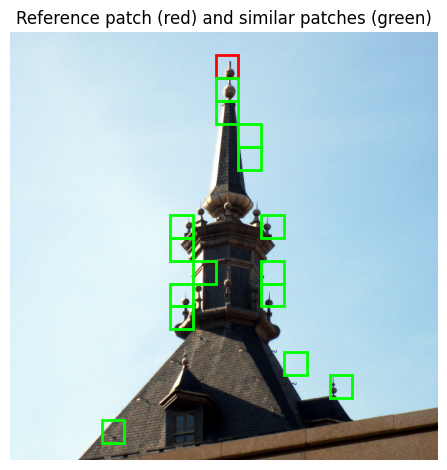

In [ ]:
proj_vectors = np.stack(proj_vectors)
sim_matrix = cosine_similarity(proj_vectors)

# --- Select reference patch ---
ref_idx = 27
ref_similarities = sim_matrix[ref_idx]

# --- Dynamic similarity threshold ---
threshold = 0.10  # Change this to control how strict the similarity is
sorted_indices = np.argsort(ref_similarities)[::-1]
sorted_indices = [i for i in sorted_indices if i != ref_idx and ref_similarities[i] > threshold]
similar_idxs = sorted_indices

print(f"🔍 Reference patch {ref_idx} matched with {len(similar_idxs)} similar patches (threshold={threshold})")

# --- Visualize result ---
fig, ax = plt.subplots()
ax.imshow(image)
ax.set_title("Reference patch (red) and similar patches (green)")

# Draw boxes
ref_x, ref_y = coords[ref_idx]
ax.add_patch(plt.Rectangle((ref_x, ref_y), patch_size, patch_size, edgecolor='red', facecolor='none', linewidth=2))
for i in similar_idxs:
    x, y = coords[i]
    ax.add_patch(plt.Rectangle((x, y), patch_size, patch_size, edgecolor='lime', facecolor='none', linewidth=2))

plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
def merge_similar_subclasses(subclass_to_indices, proj_vectors, similarity_threshold=0.9):
    """
    Merges subclasses whose mean projected vectors are very similar.

    Args:
        subclass_to_indices (dict): {subclass_id: list of patch indices}
        proj_vectors (np.ndarray): shape (num_patches, 128) — all normalized projection vectors.
        similarity_threshold (float): cosine similarity threshold for merging.

    Returns:
        merged_subclasses (list of lists): Each list contains indices of patches in one merged subclass.
    """
    # Step 1: Compute mean vector for each subclass
    subclass_means = {}
    for subclass, indices in subclass_to_indices.items():
        vectors = proj_vectors[indices]
        mean_vec = np.mean(vectors, axis=0)
        mean_vec /= np.linalg.norm(mean_vec) + 1e-8  # normalize
        subclass_means[subclass] = mean_vec

    # Step 2: Initialize disjoint sets for merging
    subclasses = list(subclass_to_indices.keys())
    parent = {s: s for s in subclasses}

    def find(s):
        while parent[s] != s:
            parent[s] = parent[parent[s]]
            s = parent[s]
        return s

    def union(s1, s2):
        root1, root2 = find(s1), find(s2)
        if root1 != root2:
            parent[root2] = root1

    # Step 3: Compare each pair of subclass means and merge if similar
    for i in range(len(subclasses)):
        for j in range(i + 1, len(subclasses)):
            si, sj = subclasses[i], subclasses[j]
            sim = np.dot(subclass_means[si], subclass_means[sj])
            if sim > similarity_threshold:
                union(si, sj)

    # Step 4: Group all indices by root
    root_to_indices = {}
    for subclass, indices in subclass_to_indices.items():
        root = find(subclass)
        if root not in root_to_indices:
            root_to_indices[root] = []
        root_to_indices[root].extend(indices)

    # Final result: list of merged subclass index groups
    merged_subclasses = list(root_to_indices.values())
    return merged_subclasses

In [ ]:
assigned = set()
subclass_to_indices = {}
subclass_id = 0

for ref_idx in range(len(proj_vectors)):
    if ref_idx in assigned:
        continue

    similarities = cosine_similarity([proj_vectors[ref_idx]], proj_vectors)[0]
    similar_idxs = np.where(similarities > threshold)[0]
    similar_idxs = [i for i in similar_idxs if i not in assigned]

    if len(similar_idxs) > 0:
        subclass_to_indices[subclass_id] = similar_idxs
        assigned.update(similar_idxs)
        subclass_id += 1

In [ ]:
merged_subclasses = merge_similar_subclasses(subclass_to_indices, proj_vectors, similarity_threshold=0.9)


In [ ]:
subclass_assignments = [-1] * len(proj_vectors)
for subclass_id, indices in enumerate(merged_subclasses):
    for idx in indices:
        subclass_assignments[idx] = subclass_id

/tmp/ipython-input-12-1749474366.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab20", len(merged_subclasses))


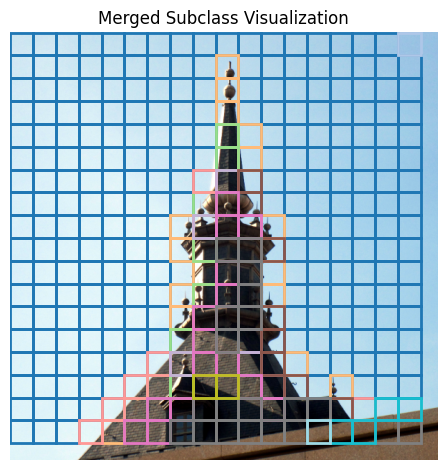

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random

fig, ax = plt.subplots()
ax.imshow(image)
ax.set_title("Merged Subclass Visualization")

colors = plt.cm.get_cmap("tab20", len(merged_subclasses))

for idx, group in enumerate(merged_subclasses):
    color = colors(idx)
    for i in group:
        x, y = coords[i]
        rect = patches.Rectangle((x, y), patch_size, patch_size,
                                 linewidth=2, edgecolor=color, facecolor='none')
        ax.add_patch(rect)

plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
len(merged_subclasses)

12

In [ ]:
import numpy as np

# --- Step 1: Flatten all latent tensors ---
# latent_tensors: shape [num_patches, 64, 2, 2]
latent_tensors = np.stack(all_latent_tensors)  # shape [N, 64, 2, 2]
flat_latents = latent_tensors.reshape(len(latent_tensors), -1)  # shape [N, 256]

# --- Step 2: Build CAPM priors per subclass ---
capm_priors = {}  # {subclass_id: {"mu": [256], "std": [256]}}

for subclass_id, patch_indices in enumerate(merged_subclasses):
    subclass_latents = flat_latents[patch_indices]  # shape: [num_patches_in_subclass, 256]

    # Compute per-component mean and std
    mu = np.mean(subclass_latents, axis=0)        # [256]
    std = np.std(subclass_latents, axis=0) + 1e-8  # Avoid divide-by-zero

    # Store
    capm_priors[subclass_id] = {
        "mu": mu,
        "std": std
    }

print(f"✅ CAPM priors computed for {len(capm_priors)} subclasses.")


✅ CAPM priors computed for 12 subclasses.


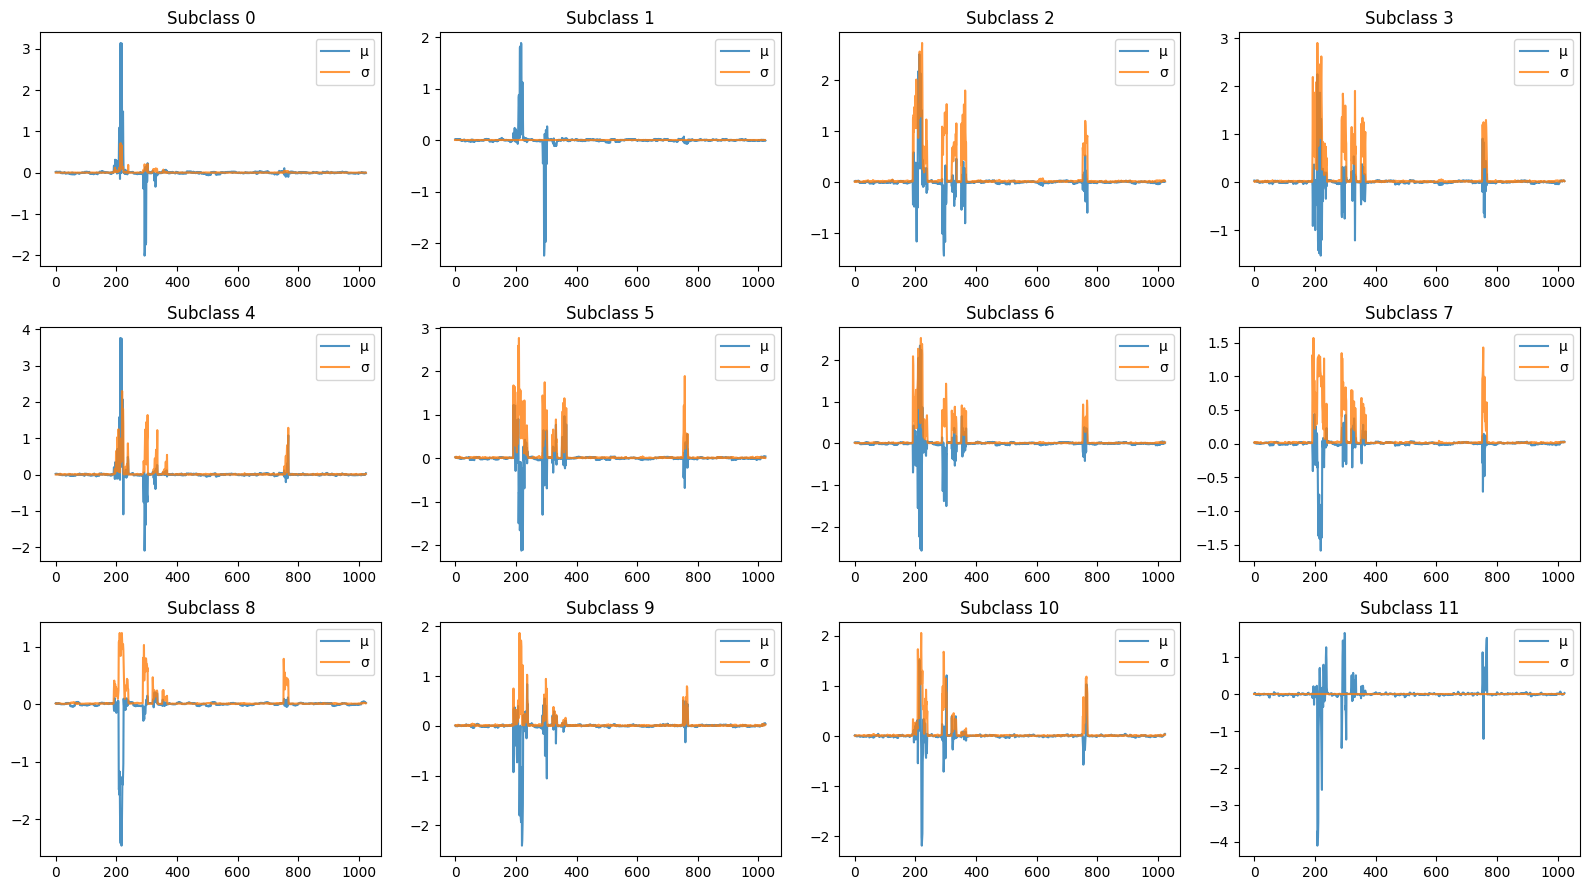

In [ ]:
import matplotlib.pyplot as plt

n_cols = 4
n_rows = (len(capm_priors) + n_cols - 1) // n_cols
fig, axs = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 3 * n_rows))

for i, (subclass_id, stats) in enumerate(capm_priors.items()):
    ax = axs[i // n_cols, i % n_cols]
    ax.plot(stats['mu'], label='μ', alpha=0.8)
    ax.plot(stats['std'], label='σ', alpha=0.8)
    ax.set_title(f"Subclass {subclass_id}")
    ax.legend()

plt.tight_layout()
plt.show()


More examples

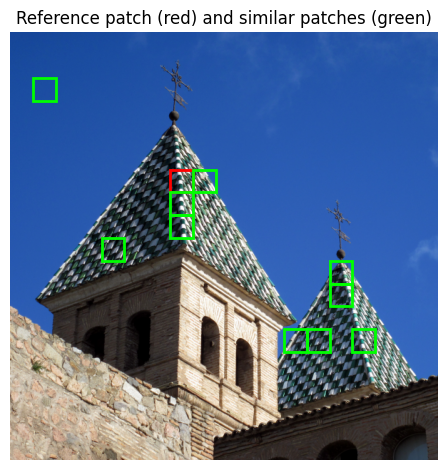

In [ ]:
image_path = "/content/drive/MyDrive/latent_exp_2025/example_images/RGB_R02_0600x0600_007.png"
vae_ckpt = "/content/drive/MyDrive/latent_exp_2025/training_ckpts_64_latent_tensors_2_2_quantized_larger_data/vae_epoch_60.pt"
simclr_ckpt = "/content/drive/MyDrive/latent_exp_2025/attention_network_checkpoints_for_quantized/attention_epoch_100.pt"

patch_size = 32
stride = 32
proj_dim = 128
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# --- VAE Definition ---
import torch.nn as nn
import torch.nn.functional as F

class PatchVAE(nn.Module):
    def __init__(self, latent_channels=64, latent_hw=2):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 4, 2, 1), nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, 1), nn.ReLU(),
            nn.Conv2d(64, 128, 4, 2, 1), nn.ReLU(),
            nn.Conv2d(128, 128, 3, 1, 1), nn.ReLU()
        )
        self.conv_mu = nn.Conv2d(128, latent_channels, 1)
        self.conv_logvar = nn.Conv2d(128, latent_channels, 1)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(latent_channels, 128, 3, 1, 1), nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1), nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, 2, 1), nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 4, 2, 1), nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def quantize_training(self, z):
        noise = torch.empty_like(z).uniform_(-0.5, 0.5)
        return z + noise

    def quantize_test(self, z):
        return torch.round(z)

    def encode(self, x, quantize=True):
        h = self.encoder(x)
        mu = self.conv_mu(h)
        logvar = self.conv_logvar(h)
        z = self.reparameterize(mu, logvar)
        z_hat = self.quantize_test(z)  # Use test-time quantization (rounding)
        return mu, logvar, z_hat

# --- SimCLR Model ---
class LatentSimCLRProjection(nn.Module):
    def __init__(self, in_channels=64, proj_dim=128):
        super().__init__()
        self.backbone = nn.Sequential(
            nn.Conv2d(in_channels, 128, 3, 1, 1), nn.ReLU(),
            nn.Conv2d(128, 256, 3, 1, 1), nn.ReLU(),
            nn.AdaptiveAvgPool2d(1), nn.Flatten()
        )
        self.projection = nn.Sequential(
            nn.Linear(256, 256), nn.ReLU(),
            nn.Linear(256, proj_dim)
        )

    def forward(self, z):
        h = self.backbone(z)
        proj = self.projection(h)
        return F.normalize(proj, dim=-1)

# --- Patch extraction ---
def extract_patches(img, patch_size=32, stride=32):
    w, h = img.size
    patches = []
    coords = []
    for top in range(0, h - patch_size + 1, stride):
        for left in range(0, w - patch_size + 1, stride):
            patch = img.crop((left, top, left + patch_size, top + patch_size))
            coords.append((left, top))
            patch_tensor = transforms.ToTensor()(patch).unsqueeze(0)  # (1, 3, 32, 32)
            patches.append(patch_tensor)
    return patches, coords

# --- Load image and models ---
image = Image.open(image_path).convert("RGB")
vae = PatchVAE().to(device)
vae.load_state_dict(torch.load(vae_ckpt, map_location=device)["model_state_dict"])
vae.eval()

simclr_model = LatentSimCLRProjection().to(device)
simclr_model.load_state_dict(torch.load(simclr_ckpt, map_location=device)["model_state_dict"])
simclr_model.eval()

patches, coords = extract_patches(image)
proj_vectors = []
all_latent_tensors = []

# --- Get latent projections ---
with torch.no_grad():
    for patch in patches:
        patch = patch.to(device)
        mu, logvar, z_hat = vae.encode(patch, quantize=True)  # quantized latent
        proj = simclr_model(z_hat)
        proj_vectors.append(proj.squeeze(0).cpu().numpy())
        all_latent_tensors.append(z_hat.squeeze(0).cpu().numpy())  # not mu

# --- Cosine similarity ---
proj_vectors = np.stack(proj_vectors)
sim_matrix = cosine_similarity(proj_vectors)

# --- Select reference patch ---
#ref_idx = len(proj_vectors) // 8  # middle patch
ref_idx = 115
top_k = 10
similar_idxs = np.argsort(sim_matrix[ref_idx])[::-1][1:top_k+1]

# --- Visualize result ---
fig, ax = plt.subplots()
ax.imshow(image)
ax.set_title("Reference patch (red) and similar patches (green)")

# Draw boxes
ref_x, ref_y = coords[ref_idx]
ax.add_patch(plt.Rectangle((ref_x, ref_y), patch_size, patch_size, edgecolor='red', facecolor='none', linewidth=2))
for i in similar_idxs:
    x, y = coords[i]
    ax.add_patch(plt.Rectangle((x, y), patch_size, patch_size, edgecolor='lime', facecolor='none', linewidth=2))

plt.axis('off')
plt.tight_layout()
plt.show()

🔍 Reference patch 1 matched with 175 similar patches (threshold=0.1)


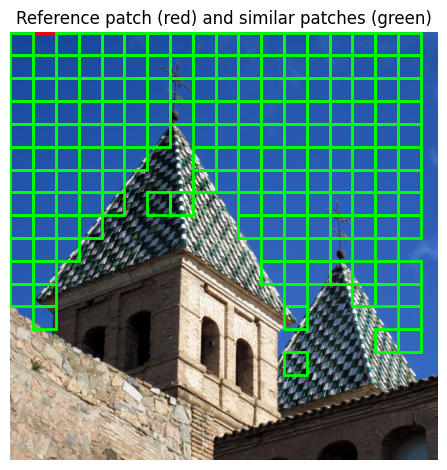

In [ ]:
proj_vectors = np.stack(proj_vectors)
sim_matrix = cosine_similarity(proj_vectors)

# --- Select reference patch ---
ref_idx = 1
ref_similarities = sim_matrix[ref_idx]

# --- Dynamic similarity threshold ---
threshold = 0.10  # Change this to control how strict the similarity is
sorted_indices = np.argsort(ref_similarities)[::-1]
sorted_indices = [i for i in sorted_indices if i != ref_idx and ref_similarities[i] > threshold]
similar_idxs = sorted_indices

print(f"🔍 Reference patch {ref_idx} matched with {len(similar_idxs)} similar patches (threshold={threshold})")

# --- Visualize result ---
fig, ax = plt.subplots()
ax.imshow(image)
ax.set_title("Reference patch (red) and similar patches (green)")

# Draw boxes
ref_x, ref_y = coords[ref_idx]
ax.add_patch(plt.Rectangle((ref_x, ref_y), patch_size, patch_size, edgecolor='red', facecolor='none', linewidth=2))
for i in similar_idxs:
    x, y = coords[i]
    ax.add_patch(plt.Rectangle((x, y), patch_size, patch_size, edgecolor='lime', facecolor='none', linewidth=2))

plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
def merge_similar_subclasses(subclass_to_indices, proj_vectors, similarity_threshold=0.9):
    """
    Merges subclasses whose mean projected vectors are very similar.

    Args:
        subclass_to_indices (dict): {subclass_id: list of patch indices}
        proj_vectors (np.ndarray): shape (num_patches, 128) — all normalized projection vectors.
        similarity_threshold (float): cosine similarity threshold for merging.

    Returns:
        merged_subclasses (list of lists): Each list contains indices of patches in one merged subclass.
    """
    # Step 1: Compute mean vector for each subclass
    subclass_means = {}
    for subclass, indices in subclass_to_indices.items():
        vectors = proj_vectors[indices]
        mean_vec = np.mean(vectors, axis=0)
        mean_vec /= np.linalg.norm(mean_vec) + 1e-8  # normalize
        subclass_means[subclass] = mean_vec

    # Step 2: Initialize disjoint sets for merging
    subclasses = list(subclass_to_indices.keys())
    parent = {s: s for s in subclasses}

    def find(s):
        while parent[s] != s:
            parent[s] = parent[parent[s]]
            s = parent[s]
        return s

    def union(s1, s2):
        root1, root2 = find(s1), find(s2)
        if root1 != root2:
            parent[root2] = root1

    # Step 3: Compare each pair of subclass means and merge if similar
    for i in range(len(subclasses)):
        for j in range(i + 1, len(subclasses)):
            si, sj = subclasses[i], subclasses[j]
            sim = np.dot(subclass_means[si], subclass_means[sj])
            if sim > similarity_threshold:
                union(si, sj)

    # Step 4: Group all indices by root
    root_to_indices = {}
    for subclass, indices in subclass_to_indices.items():
        root = find(subclass)
        if root not in root_to_indices:
            root_to_indices[root] = []
        root_to_indices[root].extend(indices)

    # Final result: list of merged subclass index groups
    merged_subclasses = list(root_to_indices.values())
    return merged_subclasses

In [ ]:
assigned = set()
subclass_to_indices = {}
subclass_id = 0

for ref_idx in range(len(proj_vectors)):
    if ref_idx in assigned:
        continue

    similarities = cosine_similarity([proj_vectors[ref_idx]], proj_vectors)[0]
    similar_idxs = np.where(similarities > threshold)[0]
    similar_idxs = [i for i in similar_idxs if i not in assigned]

    if len(similar_idxs) > 0:
        subclass_to_indices[subclass_id] = similar_idxs
        assigned.update(similar_idxs)
        subclass_id += 1

/tmp/ipython-input-43-827376930.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab20", len(merged_subclasses))


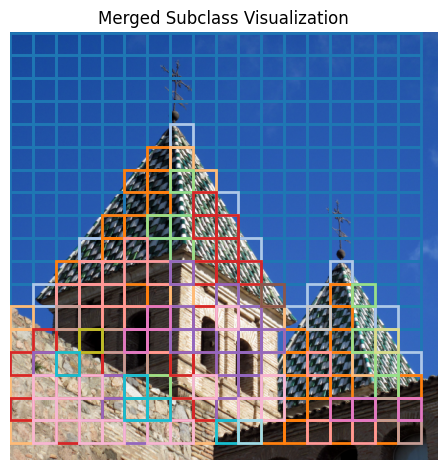

In [ ]:
merged_subclasses = merge_similar_subclasses(subclass_to_indices, proj_vectors, similarity_threshold=0.9)

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random

fig, ax = plt.subplots()
ax.imshow(image)
ax.set_title("Merged Subclass Visualization")

colors = plt.cm.get_cmap("tab20", len(merged_subclasses))

for idx, group in enumerate(merged_subclasses):
    color = colors(idx)
    for i in group:
        x, y = coords[i]
        rect = patches.Rectangle((x, y), patch_size, patch_size,
                                 linewidth=2, edgecolor=color, facecolor='none')
        ax.add_patch(rect)

plt.axis('off')
plt.tight_layout()
plt.show()


MORE EXAMPLE

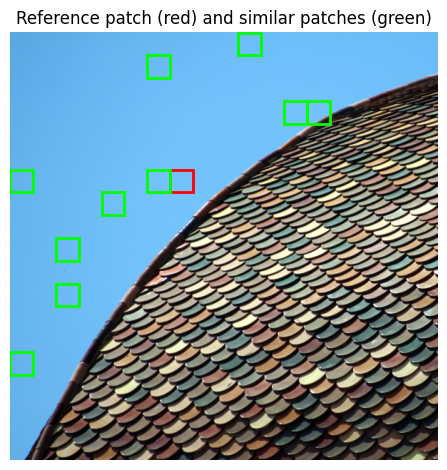

In [ ]:
image_path = "/content/drive/MyDrive/latent_exp_2025/example_images/RGB_R02_0600x0600_097.png"
vae_ckpt = "/content/drive/MyDrive/latent_exp_2025/training_ckpts_64_latent_tensors_2_2_quantized_larger_data/vae_epoch_60.pt"
simclr_ckpt = "/content/drive/MyDrive/latent_exp_2025/attention_network_checkpoints_for_quantized/attention_epoch_100.pt"

patch_size = 32
stride = 32
proj_dim = 128
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# --- VAE Definition ---
import torch.nn as nn
import torch.nn.functional as F

class PatchVAE(nn.Module):
    def __init__(self, latent_channels=64, latent_hw=2):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 4, 2, 1), nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, 1), nn.ReLU(),
            nn.Conv2d(64, 128, 4, 2, 1), nn.ReLU(),
            nn.Conv2d(128, 128, 3, 1, 1), nn.ReLU()
        )
        self.conv_mu = nn.Conv2d(128, latent_channels, 1)
        self.conv_logvar = nn.Conv2d(128, latent_channels, 1)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(latent_channels, 128, 3, 1, 1), nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1), nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, 2, 1), nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 4, 2, 1), nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def quantize_training(self, z):
        noise = torch.empty_like(z).uniform_(-0.5, 0.5)
        return z + noise

    def quantize_test(self, z):
        return torch.round(z)

    def encode(self, x, quantize=True):
        h = self.encoder(x)
        mu = self.conv_mu(h)
        logvar = self.conv_logvar(h)
        z = self.reparameterize(mu, logvar)
        z_hat = self.quantize_test(z)  # Use test-time quantization (rounding)
        return mu, logvar, z_hat

# --- SimCLR Model ---
class LatentSimCLRProjection(nn.Module):
    def __init__(self, in_channels=64, proj_dim=128):
        super().__init__()
        self.backbone = nn.Sequential(
            nn.Conv2d(in_channels, 128, 3, 1, 1), nn.ReLU(),
            nn.Conv2d(128, 256, 3, 1, 1), nn.ReLU(),
            nn.AdaptiveAvgPool2d(1), nn.Flatten()
        )
        self.projection = nn.Sequential(
            nn.Linear(256, 256), nn.ReLU(),
            nn.Linear(256, proj_dim)
        )

    def forward(self, z):
        h = self.backbone(z)
        proj = self.projection(h)
        return F.normalize(proj, dim=-1)

# --- Patch extraction ---
def extract_patches(img, patch_size=32, stride=32):
    w, h = img.size
    patches = []
    coords = []
    for top in range(0, h - patch_size + 1, stride):
        for left in range(0, w - patch_size + 1, stride):
            patch = img.crop((left, top, left + patch_size, top + patch_size))
            coords.append((left, top))
            patch_tensor = transforms.ToTensor()(patch).unsqueeze(0)  # (1, 3, 32, 32)
            patches.append(patch_tensor)
    return patches, coords

# --- Load image and models ---
image = Image.open(image_path).convert("RGB")
vae = PatchVAE().to(device)
vae.load_state_dict(torch.load(vae_ckpt, map_location=device)["model_state_dict"])
vae.eval()

simclr_model = LatentSimCLRProjection().to(device)
simclr_model.load_state_dict(torch.load(simclr_ckpt, map_location=device)["model_state_dict"])
simclr_model.eval()

patches, coords = extract_patches(image)
proj_vectors = []
all_latent_tensors = []

# --- Get latent projections ---
with torch.no_grad():
    for patch in patches:
        patch = patch.to(device)
        mu, logvar, z_hat = vae.encode(patch, quantize=True)  # quantized latent
        proj = simclr_model(z_hat)
        proj_vectors.append(proj.squeeze(0).cpu().numpy())
        all_latent_tensors.append(z_hat.squeeze(0).cpu().numpy())  # not mu

# --- Cosine similarity ---
proj_vectors = np.stack(proj_vectors)
sim_matrix = cosine_similarity(proj_vectors)

# --- Select reference patch ---
#ref_idx = len(proj_vectors) // 8  # middle patch
ref_idx = 115
top_k = 10
similar_idxs = np.argsort(sim_matrix[ref_idx])[::-1][1:top_k+1]

# --- Visualize result ---
fig, ax = plt.subplots()
ax.imshow(image)
ax.set_title("Reference patch (red) and similar patches (green)")

# Draw boxes
ref_x, ref_y = coords[ref_idx]
ax.add_patch(plt.Rectangle((ref_x, ref_y), patch_size, patch_size, edgecolor='red', facecolor='none', linewidth=2))
for i in similar_idxs:
    x, y = coords[i]
    ax.add_patch(plt.Rectangle((x, y), patch_size, patch_size, edgecolor='lime', facecolor='none', linewidth=2))

plt.axis('off')
plt.tight_layout()
plt.show()

🔍 Reference patch 1 matched with 134 similar patches (threshold=0.1)


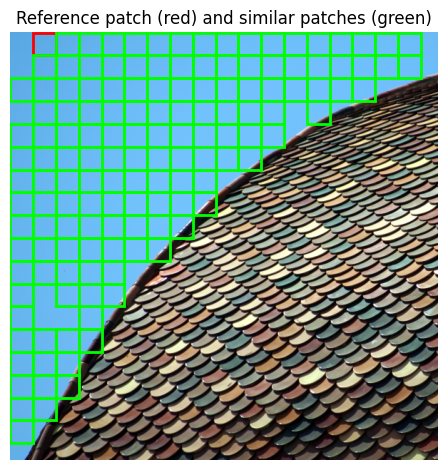

In [ ]:
proj_vectors = np.stack(proj_vectors)
sim_matrix = cosine_similarity(proj_vectors)

# --- Select reference patch ---
ref_idx = 1
ref_similarities = sim_matrix[ref_idx]

# --- Dynamic similarity threshold ---
threshold = 0.10  # Change this to control how strict the similarity is
sorted_indices = np.argsort(ref_similarities)[::-1]
sorted_indices = [i for i in sorted_indices if i != ref_idx and ref_similarities[i] > threshold]
similar_idxs = sorted_indices

print(f"🔍 Reference patch {ref_idx} matched with {len(similar_idxs)} similar patches (threshold={threshold})")

# --- Visualize result ---
fig, ax = plt.subplots()
ax.imshow(image)
ax.set_title("Reference patch (red) and similar patches (green)")

# Draw boxes
ref_x, ref_y = coords[ref_idx]
ax.add_patch(plt.Rectangle((ref_x, ref_y), patch_size, patch_size, edgecolor='red', facecolor='none', linewidth=2))
for i in similar_idxs:
    x, y = coords[i]
    ax.add_patch(plt.Rectangle((x, y), patch_size, patch_size, edgecolor='lime', facecolor='none', linewidth=2))

plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
def merge_similar_subclasses(subclass_to_indices, proj_vectors, similarity_threshold=0.9):
    """
    Merges subclasses whose mean projected vectors are very similar.

    Args:
        subclass_to_indices (dict): {subclass_id: list of patch indices}
        proj_vectors (np.ndarray): shape (num_patches, 128) — all normalized projection vectors.
        similarity_threshold (float): cosine similarity threshold for merging.

    Returns:
        merged_subclasses (list of lists): Each list contains indices of patches in one merged subclass.
    """
    # Step 1: Compute mean vector for each subclass
    subclass_means = {}
    for subclass, indices in subclass_to_indices.items():
        vectors = proj_vectors[indices]
        mean_vec = np.mean(vectors, axis=0)
        mean_vec /= np.linalg.norm(mean_vec) + 1e-8  # normalize
        subclass_means[subclass] = mean_vec

    # Step 2: Initialize disjoint sets for merging
    subclasses = list(subclass_to_indices.keys())
    parent = {s: s for s in subclasses}

    def find(s):
        while parent[s] != s:
            parent[s] = parent[parent[s]]
            s = parent[s]
        return s

    def union(s1, s2):
        root1, root2 = find(s1), find(s2)
        if root1 != root2:
            parent[root2] = root1

    # Step 3: Compare each pair of subclass means and merge if similar
    for i in range(len(subclasses)):
        for j in range(i + 1, len(subclasses)):
            si, sj = subclasses[i], subclasses[j]
            sim = np.dot(subclass_means[si], subclass_means[sj])
            if sim > similarity_threshold:
                union(si, sj)

    # Step 4: Group all indices by root
    root_to_indices = {}
    for subclass, indices in subclass_to_indices.items():
        root = find(subclass)
        if root not in root_to_indices:
            root_to_indices[root] = []
        root_to_indices[root].extend(indices)

    # Final result: list of merged subclass index groups
    merged_subclasses = list(root_to_indices.values())
    return merged_subclasses

In [ ]:
assigned = set()
subclass_to_indices = {}
subclass_id = 0

for ref_idx in range(len(proj_vectors)):
    if ref_idx in assigned:
        continue

    similarities = cosine_similarity([proj_vectors[ref_idx]], proj_vectors)[0]
    similar_idxs = np.where(similarities > threshold)[0]
    similar_idxs = [i for i in similar_idxs if i not in assigned]

    if len(similar_idxs) > 0:
        subclass_to_indices[subclass_id] = similar_idxs
        assigned.update(similar_idxs)
        subclass_id += 1

/tmp/ipython-input-62-827376930.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab20", len(merged_subclasses))


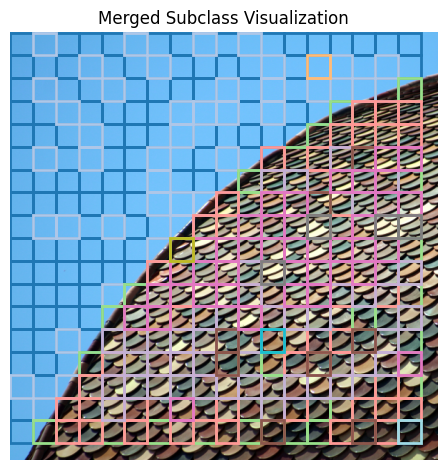

In [ ]:
merged_subclasses = merge_similar_subclasses(subclass_to_indices, proj_vectors, similarity_threshold=0.9)

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random

fig, ax = plt.subplots()
ax.imshow(image)
ax.set_title("Merged Subclass Visualization")

colors = plt.cm.get_cmap("tab20", len(merged_subclasses))

for idx, group in enumerate(merged_subclasses):
    color = colors(idx)
    for i in group:
        x, y = coords[i]
        rect = patches.Rectangle((x, y), patch_size, patch_size,
                                 linewidth=2, edgecolor=color, facecolor='none')
        ax.add_patch(rect)

plt.axis('off')
plt.tight_layout()
plt.show()


Do the following correctly

In [ ]:
def fit_capm_gaussians(subclass_to_indices, latent_tensors):
    """
    Fit a Gaussian (mu, sigma) for each component in each subclass.
    latent_tensors: List of tensors [N, C, H, W]
    Returns:
        priors: dict {subclass_id: {'mu': array, 'sigma': array}}
    """
    priors = {}
    for subclass_id, indices in subclass_to_indices.items():
        subclass_latents = np.stack([latent_tensors[i] for i in indices])  # [B, C, H, W]
        mu = np.mean(subclass_latents, axis=0)
        sigma = np.std(subclass_latents, axis=0) + 1e-6
        priors[subclass_id] = {'mu': mu, 'sigma': sigma}
    return priors

def gaussian_nll(z, mu, sigma):
    sigma = np.clip(sigma, 1e-2, None)  # prevent explosion
    return 0.5 * np.log(2 * np.pi * sigma ** 2) + 0.5 * ((z - mu) ** 2) / (sigma ** 2)

def total_bit_cost(latent_tensors, subclass_assignments, priors):
    """
    Compute total bits needed to entropy encode latent tensors using CAPM priors.
    All tensors must be quantized.
    """
    total_bits = 0.0
    for i, z in enumerate(latent_tensors):
        subclass_id = subclass_assignments[i]
        mu = priors[subclass_id]['mu']
        sigma = priors[subclass_id]['sigma']
        nll = gaussian_nll(z, mu, sigma)  # shape [C, H, W]
        total_bits += np.sum(nll) / np.log(2)  # convert nats to bits
    return total_bits

In [ ]:
subclass_to_indices = {}  # {subclass_id: [indices]}
for i, subclass_id in enumerate(subclass_assignments):
    subclass_to_indices.setdefault(subclass_id, []).append(i)

# all_latents_nonquant: shape [N, C, H, W] (z_hat from model.eval() with quantize=False)
capm_priors = fit_capm_gaussians(subclass_to_indices,all_latent_tensors)

# Step 2: Quantize each latent tensor
quantized_latents = [np.round(z) for z in all_latent_tensors]

# Step 3: Bit cost
bit_cost = total_bit_cost(quantized_latents, subclass_assignments, capm_priors)
print(f"Total Bit Cost: {bit_cost:.2f} bits")

Total Bit Cost: -829241.05 bits


**EXTRAS No nEED TO SEE**

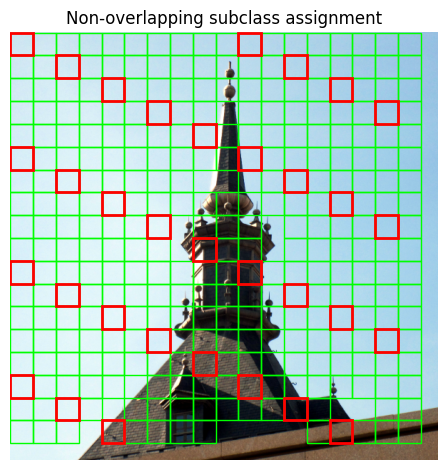

In [ ]:
# --- Cosine similarity matrix ---
proj_vectors = np.stack(proj_vectors)
sim_matrix = cosine_similarity(proj_vectors)

# --- Reference patch indices ---
stride_refs = 10  # you can change this
ref_indices = list(range(0, len(proj_vectors), stride_refs))

# --- Similarity threshold ---
threshold = 0.10  # tune this

# --- Assign each patch to most similar reference above threshold ---
assignments = [-1] * len(proj_vectors)
max_scores = [-1.0] * len(proj_vectors)

for ref_idx in ref_indices:
    for i in range(len(proj_vectors)):
        if i == ref_idx:
            continue
        sim_score = sim_matrix[ref_idx, i]
        if sim_score > threshold and sim_score > max_scores[i]:
            assignments[i] = ref_idx
            max_scores[i] = sim_score

# Optional: filter out unassigned patches
final_pairs = [(i, assignments[i]) for i in range(len(assignments)) if assignments[i] != -1]

# --- Visualize ---
fig, ax = plt.subplots()
ax.imshow(image)
ax.set_title("Non-overlapping subclass assignment")

for i, ref_idx in final_pairs:
    x, y = coords[i]
    ax.add_patch(plt.Rectangle((x, y), patch_size, patch_size, edgecolor='lime', facecolor='none', linewidth=1))

for ref_idx in ref_indices:
    x, y = coords[ref_idx]
    ax.add_patch(plt.Rectangle((x, y), patch_size, patch_size, edgecolor='red', facecolor='none', linewidth=2))

plt.axis('off')
plt.tight_layout()
plt.show()


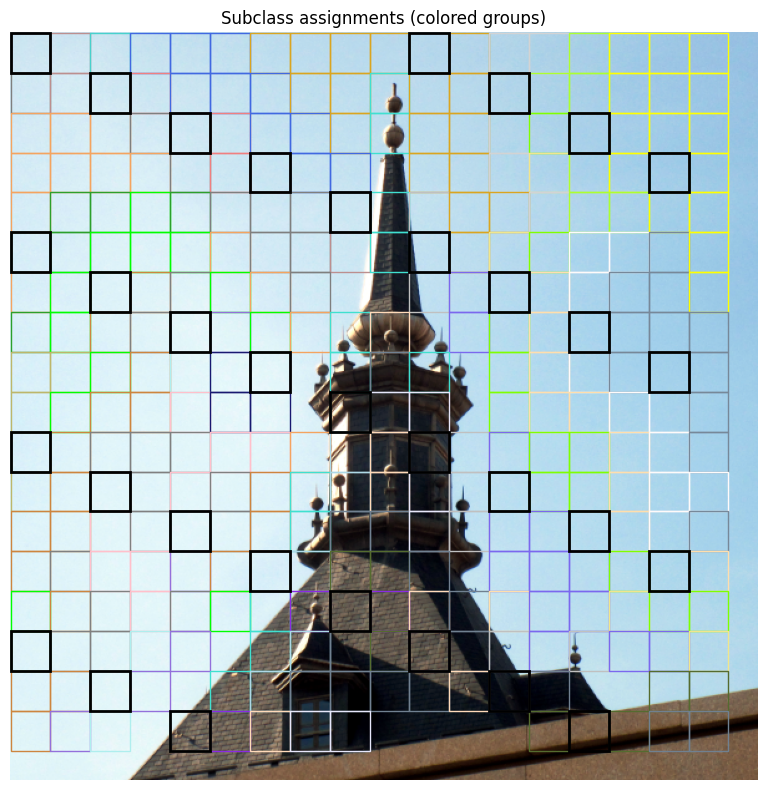

In [ ]:
import matplotlib.patches as patches
import matplotlib.colors as mcolors
import random

unique_refs = list(set(assignments) - {-1})

# --- Generate distinct colors ---
colors = list(mcolors.TABLEAU_COLORS.values())
while len(colors) < len(unique_refs):
    colors += list(mcolors.CSS4_COLORS.values())
random.shuffle(colors)

ref_to_color = {ref: colors[i % len(colors)] for i, ref in enumerate(unique_refs)}

# --- Visualize ---
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(image)
ax.set_title("Subclass assignments (colored groups)")

# Draw grouped patches with distinct colors
for i, ref_idx in final_pairs:
    x, y = coords[i]
    color = ref_to_color[ref_idx]
    ax.add_patch(patches.Rectangle((x, y), patch_size, patch_size, edgecolor=color, facecolor='none', linewidth=1))

# Draw reference patches in black
for ref_idx in unique_refs:
    x, y = coords[ref_idx]
    ax.add_patch(patches.Rectangle((x, y), patch_size, patch_size, edgecolor='black', facecolor='none', linewidth=2))

plt.axis('off')
plt.tight_layout()
plt.show()

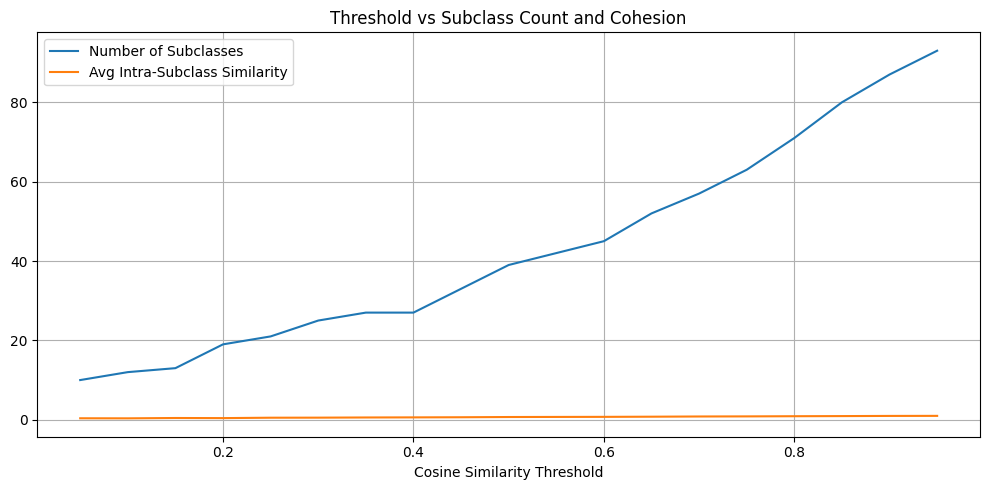

In [ ]:
sim_matrix = cosine_similarity(proj_vectors)

thresholds = np.linspace(0.05, 0.95, 19)
subclass_stats = []

for threshold in thresholds:
    assigned = set()
    subclass_groups = []

    for i in range(len(proj_vectors)):
        if i in assigned:
            continue
        sim_row = sim_matrix[i]
        similar = [j for j in range(len(sim_row)) if sim_row[j] > threshold and j not in assigned]
        if similar:
            subclass_groups.append(similar)
            assigned.update(similar)

    avg_intra_sim = []
    for group in subclass_groups:
        if len(group) < 2:
            continue
        group_sims = sim_matrix[np.ix_(group, group)]
        tri_idx = np.triu_indices(len(group), k=1)
        avg_intra_sim.append(group_sims[tri_idx].mean())

    subclass_stats.append((threshold, len(subclass_groups), np.mean(avg_intra_sim) if avg_intra_sim else 0))

# --- Plot
thresholds_plot, counts, sims = zip(*subclass_stats)
plt.figure(figsize=(10, 5))
plt.plot(thresholds_plot, counts, label="Number of Subclasses")
plt.plot(thresholds_plot, sims, label="Avg Intra-Subclass Similarity")
plt.xlabel("Cosine Similarity Threshold")
plt.title("Threshold vs Subclass Count and Cohesion")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

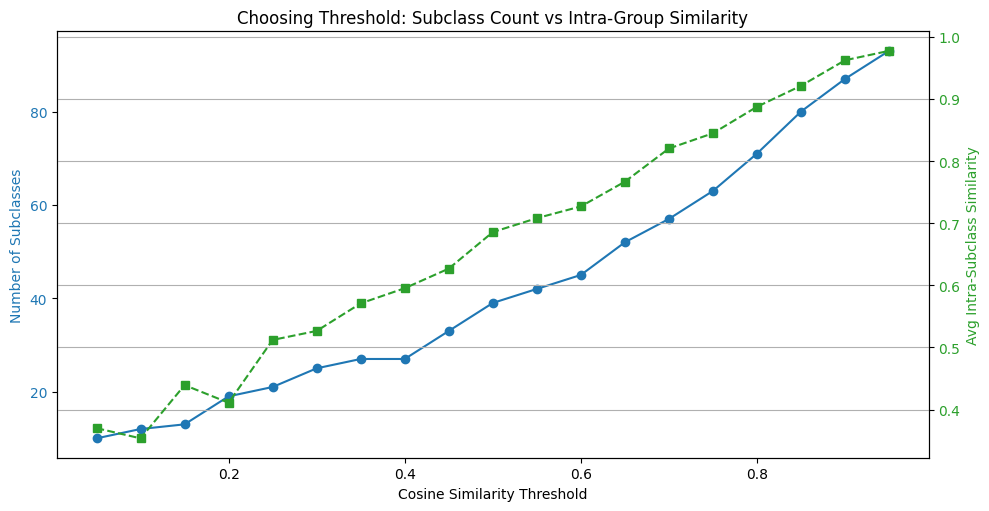

In [ ]:
fig, ax1 = plt.subplots(figsize=(10, 5))

color = 'tab:blue'
ax1.set_xlabel('Cosine Similarity Threshold')
ax1.set_ylabel('Number of Subclasses', color=color)
ax1.plot(thresholds_plot, counts, color=color, marker='o', label='Subclasses')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:green'
ax2.set_ylabel('Avg Intra-Subclass Similarity', color=color)
ax2.plot(thresholds_plot, sims, color=color, marker='s', linestyle='--', label='Intra-similarity')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title("Choosing Threshold: Subclass Count vs Intra-Group Similarity")
plt.grid(True)
plt.show()